In [1]:
#importing required libraries
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
from PIL import Image,ImageOps

In [2]:
#getting training images (downloaded from https://zenodo.org/record/1133969#.YWpD1BpByIs)
train_images_path = r'C:\Users\harsh\OneDrive\Desktop\ml cs460 project\craters\train_images.hdf5'
f = h5.File(train_images_path,'r')

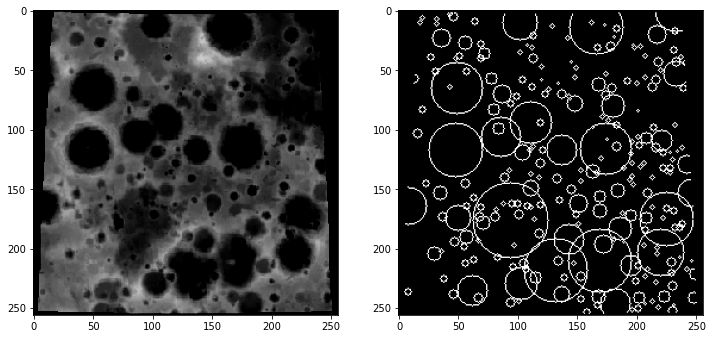

In [4]:
#showing sample dem-target pair
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(f['input_images'][10][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(f['target_masks'][10][...], origin='upper', cmap='Greys_r')
plt.show()

In [57]:
#converting hdf5 columns to numpy array and taking a portion as training set
#training set of of size 5000 images and masks
training_images = np.array(f['input_images'][10000:15000])
training_masks = np.array(f['target_masks'][10000:15000])

In [58]:
#validation images and masks (picking 2000 images and masks)
valid_images = np.array(f['input_images'][19000:21000])
valid_masks =  np.array(f['target_masks'][19000:21000])

In [59]:
#CUSTOM U-NET(https://arxiv.org/abs/1505.04597)

#first import the functions we need from keras
from keras.models import Model
from keras.layers import BatchNormalization,Input
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPool2D
from keras.layers.merge import concatenate


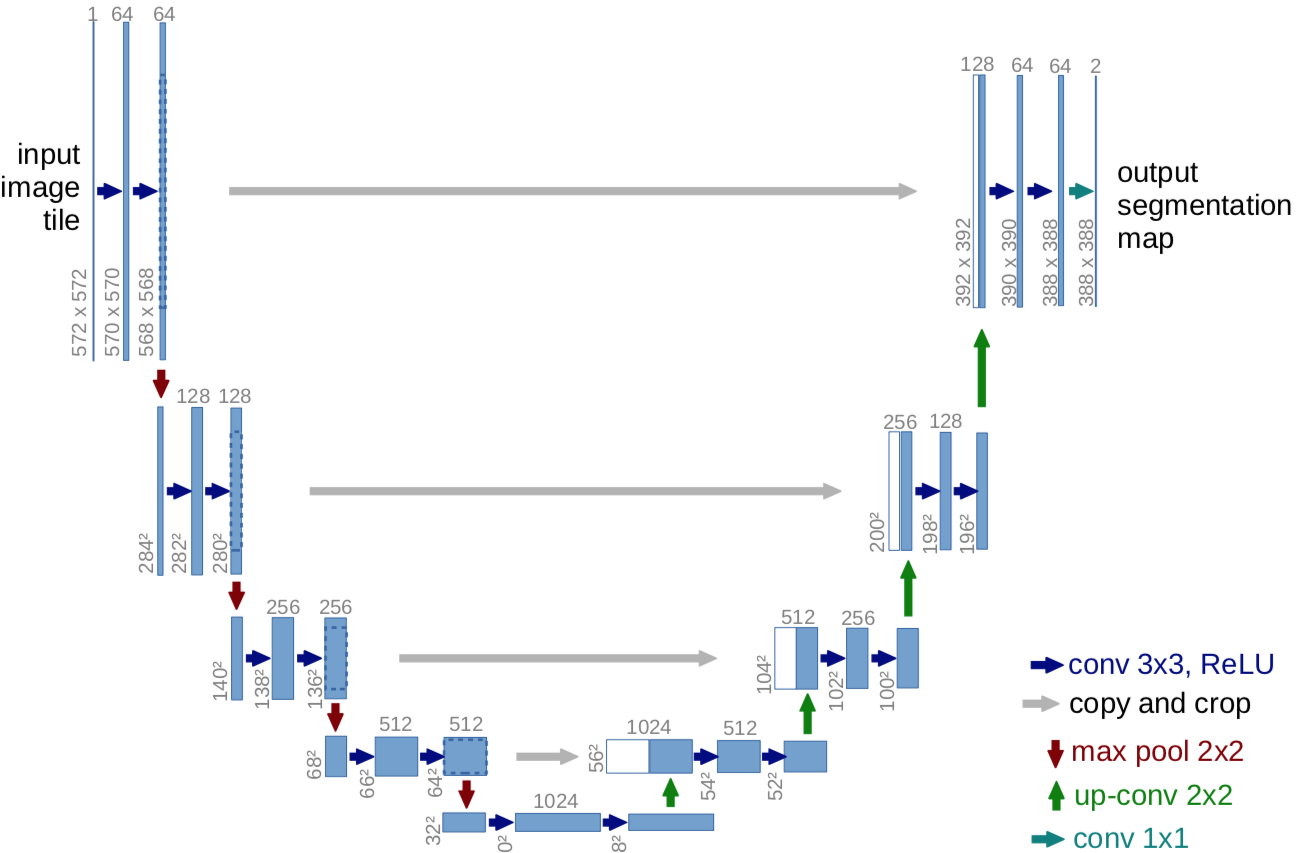

In [60]:
#references:https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5,https://idiotdeveloper.com/unet-implementation-in-tensorflow-using-keras-api/

#function that passes input through 2 3*3 conv layers
def u_conv(inputs,kernels):
    l = Conv2D(kernels,(3,3),activation = 'relu', padding = 'same')(inputs) 
    l = Conv2D(kernels,(3,3),activation = 'relu', padding = 'same')(l)
    l = BatchNormalization()(l) # adding batch normalization to ease training
    return l

#function that combines pooling step and convolution step
def u_conv_and_pool(inputs,kernels):
    o = u_conv(inputs,kernels)
    p = MaxPool2D((2,2))(o)
    p = Dropout(0.15)(p) #dropouts also added
    
    return o,p
    
#function to upsample images (using transpose convolution)    
def upsample(inputs,res_inputs,kernels):
    l = Conv2DTranspose(kernels,(3,3),strides = (2,2),padding = 'same')(inputs)
    l = concatenate([l,res_inputs])
    l = u_conv(l,kernels)
    return l
    
def make_unet(input_shape,k):
    inputs = Input(input_shape)
    
    res1, p1 = u_conv_and_pool(inputs, k) 
    res2, p2 = u_conv_and_pool(p1, 2*k)
    res3, p3 = u_conv_and_pool(p2, 4*k)
    res4, p4 = u_conv_and_pool(p3, 8*k)

    middle =  u_conv(p4, 16*k)

    d1 = upsample(middle, res4, 8*k)
    d2 = upsample(d1, res3, 4*k)
    d3 = upsample(d2, res2, 2*k)
    d4 = upsample(d3, res1, k)
    
    
    output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(d4)
    
    model = Model(inputs,output,name = 'Crater_U_Net')
    return model  

In [64]:
image_shape = (256,256,1)
k = 16 #making k small to ease training (usually 64 is used)
unet = make_unet(image_shape,k)
unet.summary()

Model: "Crater_U_Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 256, 256, 16) 160         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_95[0][0]                  
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 256, 256, 16) 64          conv2d_96[0][0]                  
_______________________________________________________________________________________

In [65]:
#setting loss to be trained on (using binary cross entropy because at the pixel level this problem is a two class classfication)
unet.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.BinaryAccuracy(threshold = 0.5)])

In [67]:
valid_data = (valid_images,valid_masks)
history = unet.fit(x=training_images,y=training_masks,validation_data = valid_data,epochs = 5)

Epoch 1/5
157/157 [==============================] - 2033s 13s/step - loss: 0.4609 - binary_accuracy: 0.9445 - val_loss: 0.3187 - val_binary_accuracy: 0.9640
Epoch 2/5
157/157 [==============================] - 2042s 13s/step - loss: 0.1873 - binary_accuracy: 0.9707 - val_loss: 0.1543 - val_binary_accuracy: 0.9692
Epoch 3/5
157/157 [==============================] - 2040s 13s/step - loss: 0.1172 - binary_accuracy: 0.9708 - val_loss: 0.1127 - val_binary_accuracy: 0.9707
Epoch 4/5
157/157 [==============================] - 2036s 13s/step - loss: 0.0999 - binary_accuracy: 0.9709 - val_loss: 0.1084 - val_binary_accuracy: 0.9710
Epoch 5/5
157/157 [==============================] - 2199s 14s/step - loss: 0.0929 - binary_accuracy: 0.9710 - val_loss: 0.0973 - val_binary_accuracy: 0.9699


In [68]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

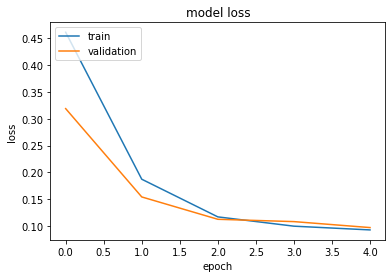

In [69]:
#Plotting epoch vs loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

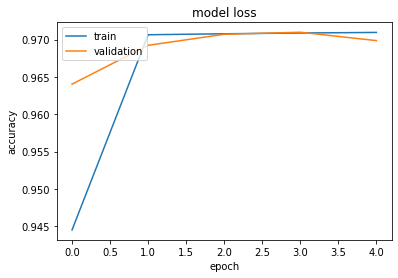

In [78]:
#Plotting epoch vs accuracy 
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [70]:
#predictions for test set(taking first 1000 as test set)
test_images = np.array(f['input_images'][0:1000])
test_preds = unet.predict(test_images)

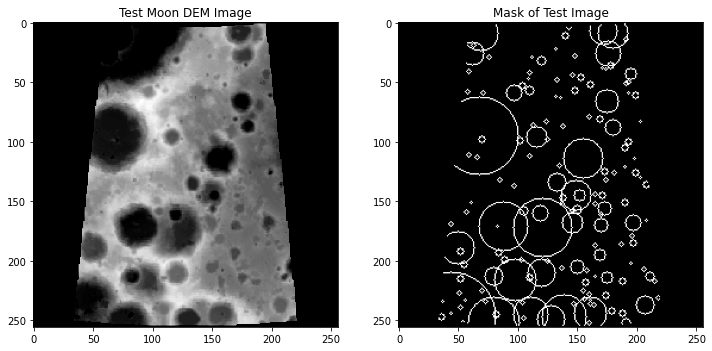

In [76]:
#test input image and mask
test = test_preds[100]
fig = plt.figure(figsize=[12, 6])
[ax1,ax2] = fig.subplots(1,2)
ax1.imshow(f['input_images'][100][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(f['target_masks'][100][...], origin='upper', cmap='Greys_r')
ax1.set_title('Test Moon DEM Image')
ax2.set_title('Mask of Test Image')
plt.show()

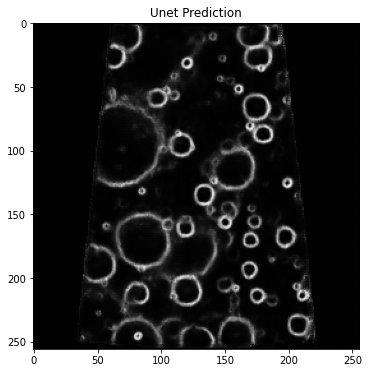

In [77]:
#Showing sample output of Unet
fig = plt.figure(figsize=[12, 6])
ax3 = fig.subplots(1,1)
ax3.imshow(test, origin='upper', cmap='Greys_r', vmin=0, vmax=1)
ax3.set_title('Crater U-Net Prediction')
plt.show()